### Imports

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date
from sympy import symbols, solve
from pathlib import Path 
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_squared_log_error

### Functions

In [2]:
def addTime(startDate, t): 
    dates = datetime.strptime(startDate, '%Y-%m-%d').date()
    d = dates+ timedelta(days = t)
    return d.strftime('%Y-%m-%d')
def timeTot(startDate, endDate):
    sD = startDate.split('-')
    sDs = date(int(sD[0]),int(sD[1]),int(sD[2]))
    eD = endDate.split('-')
    eDs = date(int(eD[0]),int(eD[1]),int(eD[2]))
    delta = eDs - sDs
    return delta.days

In [3]:
def plotRealData (graph, data, offset, beforeForecast, D, minus, manipulate=False):
    if (manipulate==False):
        deaths = data["cumDeath"].tolist()
        deaths = [x-minus for x in deaths]
    else:
        deaths = data["cumDeath"]-data["cumDeath"].loc[offset]
        deaths = deaths.to_list()
        deaths = [x+minus for x in deaths]
    t = np.linspace(0, len(deaths), len(deaths))
    graph.plot(t, deaths, 'r', marker='.', label="Data", linestyle = 'None')
    legend = graph.legend()
    legend.get_frame().set_alpha(0.5)
    return graph

### SIRD Model
differential equation of the SIRD model.

In [4]:
# SIRD model divided into its equations
def deriv(y, t, N, beta, gamma, rho):
    S, I, R, D= y
    dSdt = -(beta * S * I) / N
    dIdt = (beta * S * I / N) - ((gamma+rho) * I)
    dRdt = gamma * I
    dDdt = rho * I
    return dSdt, dIdt, dRdt, dDdt

In [5]:
def plotSIRD(ax, tf, N, i0, beta, gamma, rho, ylimit, xlimit, sd, offset, sird_true, name, value):
    t = np.linspace(0, tf, tf)

    y0 = N-i0, i0, 0, 0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, rho))
    S, I, R, D = ret.T

    # Add base value to the D values
    D = D + value


    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta-sd[0], gamma-sd[1], rho-sd[2]))
    Sm, Im, Rm, Dm = ret.T 

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta+sd[0], gamma+sd[1], rho+sd[2]))
    Sp, Ip, Rp, Dp = ret.T 


    # Plotting SIRD data point
    if (sird_true):
        ax.plot(t+offset, S, 'b', alpha=0.5, lw=2, label='Susceptible')
        ax.plot(t+offset, I, 'r', alpha=0.5, lw=2, label='Infected')
        ax.plot(t+offset, R, 'g', alpha=0.5, lw=2, label='Recovered')
        ax.plot(t+offset, D, 'y', alpha=0.5, lw=2, label='Deceased')
    else:
        ax.plot(t+offset, D, alpha=1, lw=2, label=name)


    # Creating Labels for graph
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Deceased')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    ax.set_xlim([xlimit[0], xlimit[1]])
    ax.set_ylim([ylimit[0], ylimit[1]])
    ax.set_label(name)
    # ax.fill_between(t+offset, Dm, Dp, alpha=0.2, edgecolor='black',  label="Standard Deviation")
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    return D

In [6]:
def getSIRD(tf, N, i0, beta, gamma, rho, sd):
    t = np.linspace(0, tf, tf)

    y0 = N-i0, i0, 0, 0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, rho))
    S, I, R, D = ret.T

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta-sd[0], gamma-sd[1], rho-sd[2]))
    Sm, Im, Rm, Dm = ret.T 

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta+sd[0], gamma+sd[1], rho+sd[2]))
    Sp, Ip, Rp, Dp = ret.T 

    return S,I,R,D

In [7]:
dataset = {
'Switzerland' : {
        'data' : pd.read_csv("../processed_data/cumDeathSwitzerland.csv"),
        'fLock' : ['2020-03-17', '2020-04-27'],
        'sLock' : ['2021-01-18', '2021-03-01'],
        'pop' : 8570146
        },
    'Sweden' : {
        'data' : pd.read_csv("../processed_data/cumDeathSweden.csv"),
        'fLock' : ['2020-03-15', '2020-04-06'],
        'sLock' : ['2020-12-15', '2021-06-05'],
        'pop' : 10420000
        },
    'Italy' : {
        'data' : pd.read_csv("../processed_data/cumDeathItaly.csv"),
        'fLock' : ['2020-03-09','2020-05-18'], 
        'sLock' : ['2020-12-24','2021-01-06'],
        'pop': 59110000
              }
}

### R2 and RMSE

#### Additive

In [8]:
country_names = ['Sweden','Switzerland','Italy']
values = []
for country in country_names:
    df = pd.DataFrame(columns=['days','adj-r2','rmse','aic'])
    pop = dataset[country]['pop']
    df_real = dataset[country]['data']

    # Get beginning of lockdown date
    startDate = dataset[country]['fLock'][0]

    # Get the index of the date
    startDate = df_real[df_real['date'] == startDate].index

    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']


    for x in range(0,18,3):
        # Plug in parameters to the SIRD differential equation
        df_param = pd.read_csv('mcmc_data/'+country+"/analysis_"+str(x/3)+'.csv')
        
        # Run the SIRD model with the selected parameters, and obtain the values from the D compartment.
        sird = getSIRD(100,pop, df_param.loc[3][1],df_param.loc[0][1],df_param.loc[1][1],df_param.loc[2][1], [df_param.loc[0][2], df_param.loc[1][2], df_param.loc[2][2]] )


        deaths = df_real["cumDeath"].tolist()
        deaths_previous = deaths[startDate[0]-11]
        deaths = deaths[startDate[0]-10:startDate[0]+(x+5)]
        
        # Predicted Deaths
        # Get the D compartment values
        deaths_predicted = sird[3]
        # Add the deaths from before the simulation began
        deaths_predicted = deaths_predicted[0:15+x] + deaths_previous
        
        # Calculate different diagnostical values
        r2 = r2_score(deaths, deaths_predicted)
        r2 = 1 - (1-r2)*(len(deaths)-1)/(len(deaths)-5-1)
        rmse =  np.sqrt(mean_squared_log_error(deaths, deaths_predicted))
        n = len(deaths)
        k = 4 # number of parameters (beta and gamma)
        rss = np.sum((deaths-deaths_predicted)**2)
        aic = n * np.log(rss/n) + 2 * k
        df1 = pd.DataFrame(
        {
            "days": (x),
            "adj-r2": r2,
            "rmse": rmse,
            "aic": aic
        }, index=[0])
        df = pd.concat([df,df1])

    values.append(df)

In [9]:
country_names = ['Sweden','Switzerland','Italy']
for index, x in enumerate(values):
    print(country_names[index])
    display(x)

Sweden


,days,adj-r2,rmse,aic
0,0,0.965155,0.192190,15.792055
0,3,0.968931,0.474878,43.691794
0,6,0.966424,0.368312,82.876922
0,9,0.981104,0.703848,109.832354
0,12,0.979114,0.932668,152.282255
0,15,0.988657,0.960040,177.106646


Switzerland


,days,adj-r2,rmse,aic
0,0,0.887047,0.216475,69.850655
0,3,0.973968,0.207001,76.497422
0,6,0.992106,0.237832,84.980816
0,9,0.988430,0.350737,127.771300
0,12,0.984534,0.534572,170.776012
0,15,0.971849,0.705528,224.256688


Italy


,days,adj-r2,rmse,aic
0,0,0.919480,0.147165,142.085640
0,3,0.986098,0.258849,158.012867
0,6,0.987630,0.410219,201.138741
0,9,0.994909,0.395076,229.747805
0,12,0.981380,0.642446,312.173600
0,15,0.981480,0.720095,363.872241


#### Rolling

In [10]:
country_names = ['Sweden','Switzerland','Italy']
values = []
for country in country_names:
    df = pd.DataFrame(columns=['days','adj-r2','rmse','aic'])
    pop = dataset[country]['pop']
    df_real = dataset[country]['data']

    # Get beginning of lockdown date
    startDate = dataset[country]['fLock'][0]

    # Get the index of the date
    startDate = df_real[df_real['date'] == startDate].index

    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']


    for x in range(0,18,3):
        # Plug in parameters to the SIRD differential equation
        df_param = pd.read_csv('mcmc_data/'+country+"/analysis_"+str(x/3)+'_second_version.csv')
        sird = getSIRD(100,pop, df_param.loc[3][1],df_param.loc[0][1],df_param.loc[1][1],df_param.loc[2][1], [df_param.loc[0][2], df_param.loc[1][2], df_param.loc[2][2]] )

        deaths = df_real["cumDeath"].tolist()
        deaths_previous = deaths[startDate[0]-11+x]
        deaths = deaths[startDate[0]-10+x:startDate[0]+(x+5)]
        
        deaths_predicted = sird[3]
        deaths_predicted = deaths_predicted[0:15] + deaths_previous
        r2 = r2_score(deaths, deaths_predicted)
        r2 = 1 - (1-r2)*(len(deaths)-1)/(len(deaths)-5-1)
        rmse =  np.sqrt(mean_squared_log_error(deaths, deaths_predicted))
        # Calculate AIC
        n = len(deaths)
        k = 4 # number of parameters (beta and gamma)
        rss = np.sum((deaths-deaths_predicted)**2)
        aic = n * np.log(rss/n) + 2 * k
        df1 = pd.DataFrame(
        {
            "days": (x),
            "adj-r2": r2,
            "rmse": rmse,
            "aic": aic
        }, index=[0])
        df = pd.concat([df,df1])

    values.append(df)

In [11]:
country_names = ['Sweden','Switzerland','Italy']
for index, x in enumerate(values):
    print(country_names[index])
    display(x)

Sweden


,days,adj-r2,rmse,aic
0,0,0.968268,0.161852,14.388169
0,3,0.967645,0.217217,37.994826
0,6,0.950358,0.140224,66.775237
0,9,0.973408,0.141259,75.735190
0,12,0.981457,0.158732,84.313127
0,15,0.989304,0.081702,88.577367


Switzerland


,days,adj-r2,rmse,aic
0,0,0.940562,0.224765,60.219932
0,3,0.953867,0.263450,72.251113
0,6,0.972483,0.114795,79.274063
0,9,0.980320,0.133546,87.272068
0,12,0.989597,0.077742,87.417368
0,15,0.994702,0.048026,83.476161


Italy


,days,adj-r2,rmse,aic
0,0,0.935409,0.131398,138.779110
0,3,0.976603,0.147376,139.596984
0,6,0.986786,0.106565,144.408043
0,9,0.981928,0.177487,161.890098
0,12,0.982626,0.097140,170.508107
0,15,0.984783,0.066820,175.428118


### Graph

In [12]:
def plotAdditive(country):
    names=["0 Days Added","3 Days Added","6 Days Added","9 Days Added","12 Days Added","15 Days Added","Observed Data"]
    fildesDir = "mcmc_data/"+country+"/"
    fig, (ax1) = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    file_list = [str(x) for x in Path(fildesDir).rglob('analysis_*.csv') if "second_version" not in str(x)]
    file_list.sort()
    for file in file_list:
        # Plot the data on three separate curves for S(t), I(t) and R(t)
        
        pop = dataset[country]['pop']
        startDate = dataset[country]['fLock'][0]
        realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
        firstDate = realData.loc[0]['date']


        obvData_start = timeTot(firstDate,startDate)-10
        obvData_end = timeTot(firstDate,addTime(startDate,20))
        add = dataset[country]['data'].iloc[[obvData_start]]['cumDeath']
        df = pd.read_csv(file)
        graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+20], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False, file, add.values[0])

    final_graph =plotRealData(ax1, realData, obvData_start, obvData_end-10, graph,0)
    ax1.set_title(country + " Analysis (Additive)")
    ax1.legend(names,loc='center left', bbox_to_anchor=(1, 0.5))

def plotRolling (country):
    names=["$q_{-10}$ - $q_{5}$","$q_{-7}$ - $q_{8}$","$q_{-4}$ - $q_{12}$","$q_{-1}$ - $q_{15}$","$q_{2}$ - $q_{18}$","$q_{5}$ - $q_{21}$","Observed data"]
    fildesDir = "mcmc_data/"+country+"/"
    fig, (ax1) = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    file_list = [str(x) for x in Path(fildesDir).rglob('analysis_*.csv') if "second_version" in str(x)]
    file_list.sort()
    count = 0
    for file in file_list:
        # Plot the data on three separate curves for S(t), I(t) and R(t)
        
        pop = dataset[country]['pop']
        startDate = dataset[country]['fLock'][0]
        realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
        firstDate = realData.loc[0]['date']


        obvData_start = timeTot(firstDate,startDate)-10
        obvData_end = timeTot(firstDate,addTime(startDate,20))
        add = dataset[country]['data'].iloc[[obvData_start+count]]['cumDeath']
        df = pd.read_csv(file)
        graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+20], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10+count, False, file, add.values[0])
        count = count + 3

    final_graph =plotRealData(ax1, realData, obvData_start, obvData_end-10, graph,0)
    ax1.set_title(country + " Analysis (Rolling)")
    ax1.legend(names,loc='center left', bbox_to_anchor=(1, 0.5))

#### Sweden

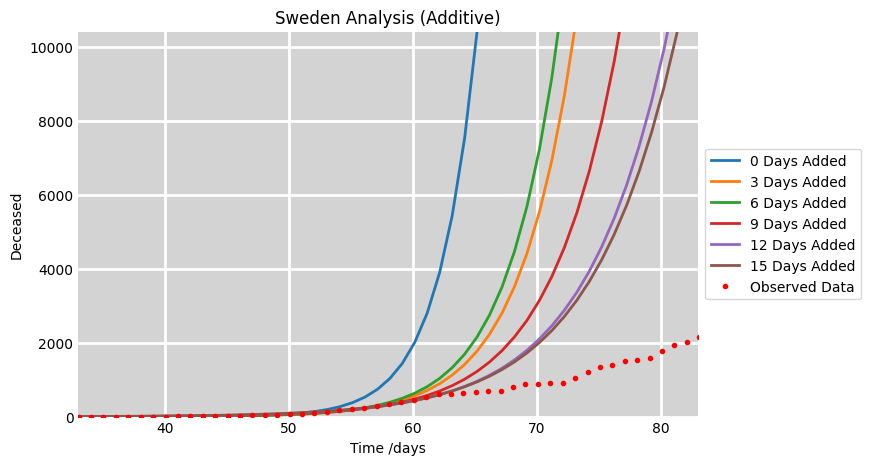

In [13]:
plotAdditive("Sweden")

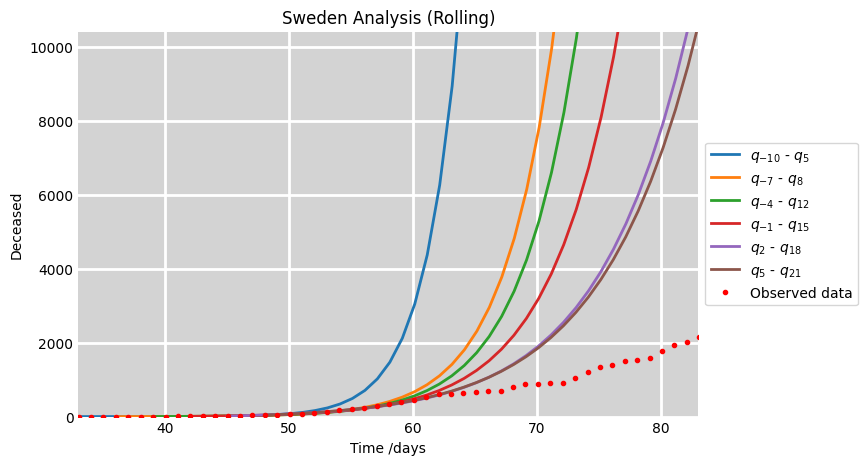

In [14]:
plotRolling("Sweden")

#### Switzerland

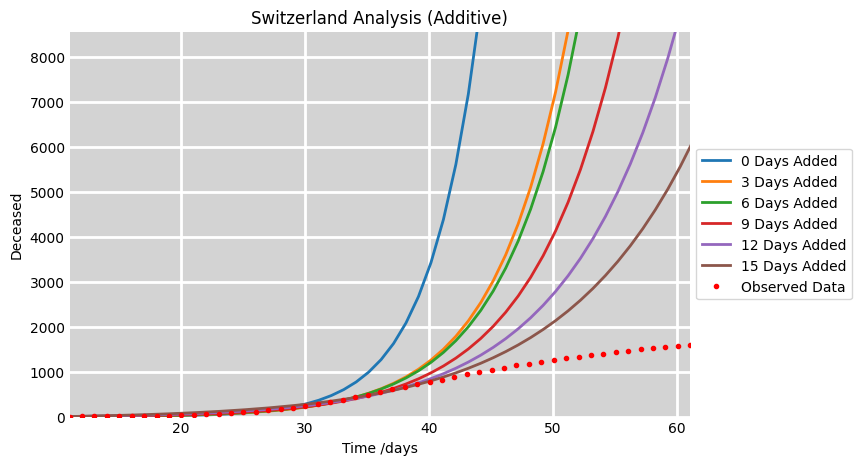

In [15]:
plotAdditive("Switzerland")

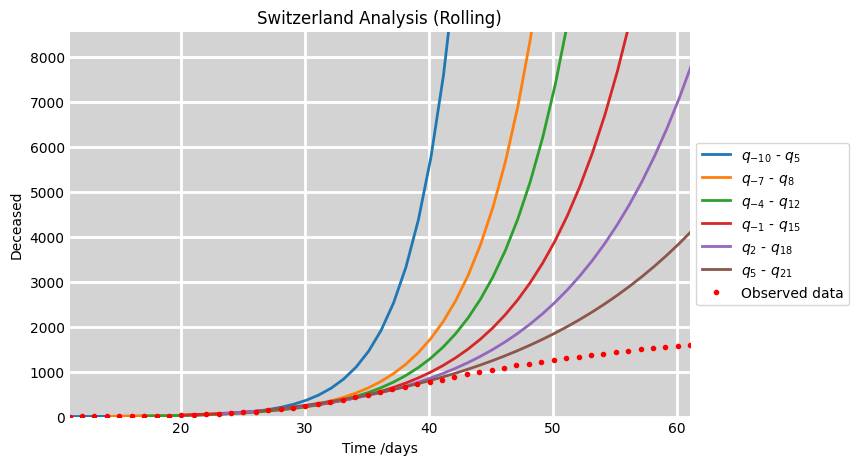

In [16]:
plotRolling("Switzerland")

#### Italy

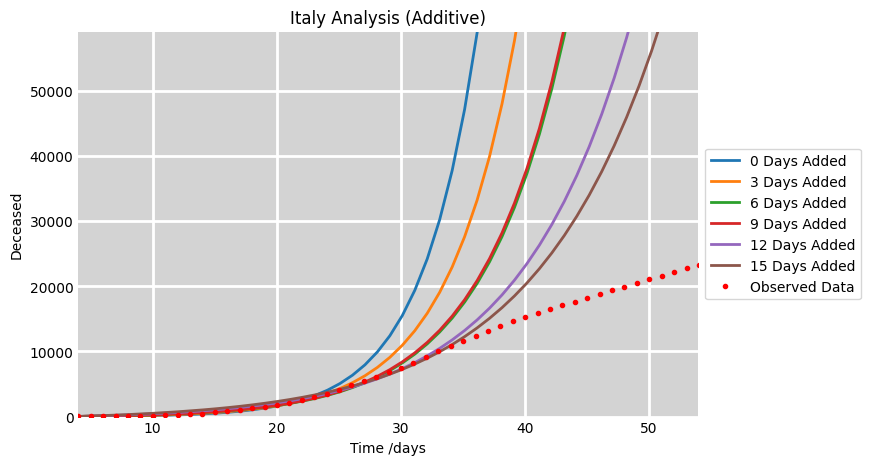

In [67]:
plotAdditive("Italy")

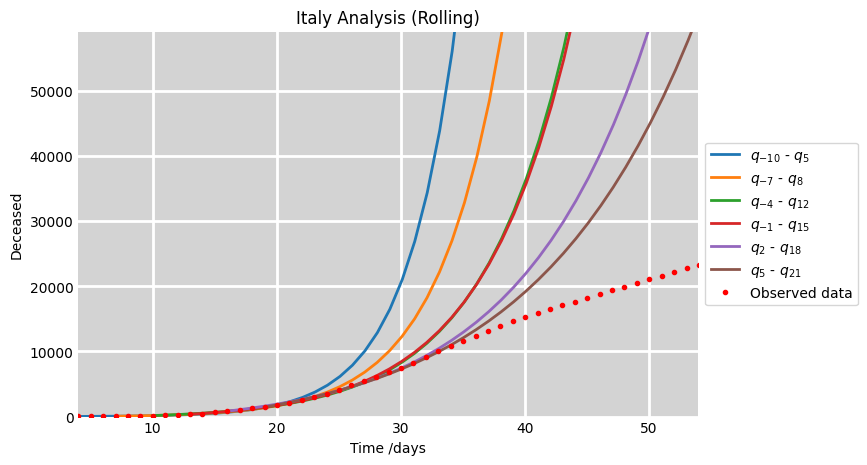

In [68]:
names=["$q_{-10}$ - $q_{5}$","$q_{-7}$ - $q_{8}$","$q_{-4}$ - $q_{12}$","$q_{-1}$ - $q_{15}$","$q_{2}$ - $q_{18}$","$q_{5}$ - $q_{21}$","Observed data"]
country_names = ['Italy']
sird_deaths = {}
fildesDir = "mcmc_data/Italy/"
country = "Italy"
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))    
ax1.set_facecolor('lightgrey')
r_italy = []
file_list = [str(x) for x in Path(fildesDir).rglob('analysis_*.csv') if "second_version" in str(x)]
file_list.sort()
count = 0 
for file in file_list:
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']

    obvData_start = timeTot(firstDate,startDate)-10
    obvData_end = timeTot(firstDate,addTime(startDate,20))
    add = dataset[country]['data'].iloc[[obvData_start+count]]['cumDeath']
    df = pd.read_csv(file)
    r_italy.append(df.loc[4][1])
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+20], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10+count, False, file, add.values[0])
    count = count + 3

final_graph =plotRealData(ax1, realData, obvData_start, obvData_end-10, graph,0)
ax1.set_title(country + " Analysis (Rolling)")
ax1.legend(names,loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('results/sweden_analysis/'+country+'.png')

### Change in R0

In [19]:
def getR(country):
    fildesDir = "mcmc_data/"+country+"/"
    file_list = [str(x) for x in Path(fildesDir).rglob('analysis_*.csv') if "second_version" in str(x)]
    file_list.sort()
    r = []
    for file in file_list:
        df = pd.read_csv(file)
        r.append(df.loc[4][1])
    return r

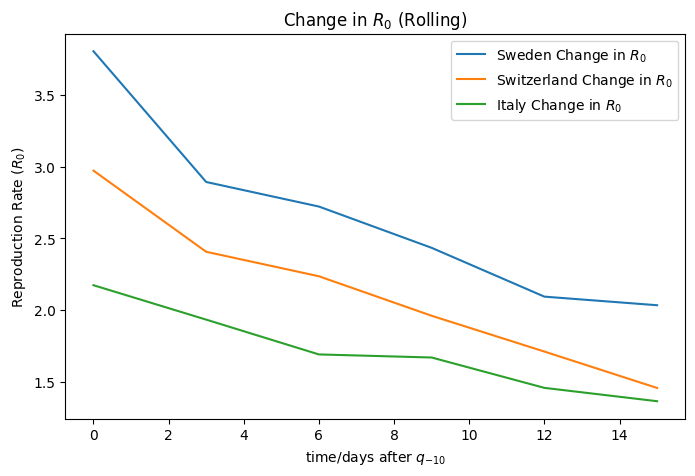

In [20]:
x = [0,3,6,9,12,15]
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))    
ax1.plot(x,getR("Sweden"), label="Sweden Change in $R_0$")
ax1.plot(x,getR("Switzerland"), label="Switzerland Change in $R_0$")
ax1.plot(x,getR("Italy"), label="Italy Change in $R_0$")
ax1.set_title("Change in $R_0$ (Rolling)")
ax1.set_xlabel("time/days after $q_{-10}$")
ax1.set_ylabel("Reproduction Rate ($R_0$)")
ax1.legend()